In [1]:
# This program processes the vertebrae ground truth masks into normalised sets of 3 input points and 1 target point which can be used to train the point predictor

import os
import numpy as np
from skimage.measure import regionprops
import matplotlib.pyplot as plt
from PIL import Image

VERTEBRA_DICT = {'C2':1,'C3':2,'C4':3,'C5':4,'C6':5,'C7':6,'T1':7,'T12':8,'L1':9,'L2':10,'L3':11,'L4':12,'L5':13,'S1':14}
data_path = os.path.join('..','..','..','data','NHANES2','point_predictor_v2')
os.makedirs(data_path,exist_ok=True)

gt_path = os.path.join(data_path,'..','Vertebrae','gts')
gt_filenames = [filename for filename in os.listdir(gt_path)]

In [2]:
# Function to rotate a point around a center
def rotate_point(point, center, angle_deg):
    # Convert angle to radians
    angle_rad = -1*np.deg2rad(angle_deg)
    
    # Shift the point to the origin relative to the center
    shifted_x = point[0] - center[0]
    shifted_y = point[1] - center[1]
    
    # Apply 2D rotation matrix
    new_x = shifted_x * np.cos(angle_rad) - shifted_y * np.sin(angle_rad)
    new_y = shifted_x * np.sin(angle_rad) + shifted_y * np.cos(angle_rad)
    
    # Shift back to the original center
    rotated_x = new_x + center[0]
    rotated_y = new_y + center[1]
    
    return (rotated_x, rotated_y)

In [4]:
centroid_dict = {}

for filename in gt_filenames:
    
    id = filename.split('_')[0]
    level = filename.split('_')[1].split('.')[0]

    if id not in centroid_dict.keys():
        centroid_dict[id] = {}

    mask = np.load(os.path.join(gt_path,filename)).astype(np.uint8)
    h,w = mask.shape[-2:]

    c_y,c_x = regionprops(mask)[0]['centroid']
    #c_x,c_y = c_x/w,c_y/h

    centroid_dict[id][VERTEBRA_DICT[level]] = (c_x,c_y)

In [5]:
input_points_dict = {}
output_points_dict = {}

for id,dict in centroid_dict.items():
    
    input_points_dict[id] = []
    output_points_dict[id] = []

    sorted_points = [dict[level] for level in sorted(dict.keys())]
    for i in range(len(sorted_points)-2):
        points = sorted_points[i:i+3]

        input_points_dict[id].append(points[:-1])
        input_points_dict[id].append(points[:0:-1])

        output_points_dict[id].append(points[-1])
        output_points_dict[id].append(points[0])

In [54]:
import math
import pickle

labels = {}

os.makedirs(os.path.join(data_path,'imgs'),exist_ok=True)

for id in input_points_dict.keys():

    input_points = input_points_dict[id]
    output_points = output_points_dict[id]
    base_img = Image.open(os.path.join(data_path,'..','Vertebrae','imgs',id+'.jpg')).convert('RGB')

    for n,(((x1,y1),(x2,y2)),output) in enumerate(zip(input_points,output_points)):

        
        w = (((x2-x1)**2)+((y2-y1)**2))**0.5
        theta = math.atan2((y2-y1),(x2-x1))*180/math.pi
        center = (2*x2-x1,2*y2-y1)

        img = base_img.rotate(theta)
        rxo,ryo = rotate_point(output,(img.size[0]/2,img.size[1]/2),theta)
        rxc,ryc = rotate_point(center,(img.size[0]/2,img.size[1]/2),theta)

        img = img.crop((rxc-2*w,ryc-w,rxc+w,ryc+w))
        img = img.resize((224, 224))

        rxo,ryo = (rxo-rxc+2*w)*224/(3*w),(ryo-ryc+w)*224/(2*w)
        
        name = id+'_'+str(n)
        labels[name] = (rxo,ryo)

        img.save(os.path.join(data_path,'imgs',name+'.jpg'))



In [47]:
with open(os.path.join(data_path,'labels.txt',),'rb') as f:
    labels = pickle.load(f)

In [7]:

from utils import *

for id in input_points_dict.keys():

    input_points = input_points_dict[id]
    output_points = output_points_dict[id]
    base_img = Image.open(os.path.join(data_path,'..','Vertebrae','imgs',id+'.jpg')).convert('RGB')

    for n,(((x1,y1),(x2,y2)),output) in enumerate(zip(input_points,output_points)):

        # plt.imshow(base_img)
        # plt.scatter((x1,x2),(y1,y2))
        # plt.scatter(output[0],output[1])


        w = (((x2-x1)**2)+((y2-y1)**2))**0.5
        theta = math.atan2((y2-y1),(x2-x1))*180/math.pi
        center = (2*x2-x1,2*y2-y1)

        img = base_img.rotate(theta)
        rxo,ryo = rotate_point(output,(img.size[0]/2,img.size[1]/2),theta)
        rxc,ryc = rotate_point(center,(img.size[0]/2,img.size[1]/2),theta)

        # plt.imshow(img)
        # plt.scatter(rxc,ryc)
        # plt.scatter(rxo,ryo)

        img = img.crop((rxc-2*w,ryc-w,rxc+w,ryc+w))
        img = img.resize((224, 224))

        rxo,ryo = (rxo-rxc+2*w)*224/(3*w),(ryo-ryc+w)*224/(2*w)
        
        PointPredictor = get_model
    break

ModuleNotFoundError: No module named 'models'

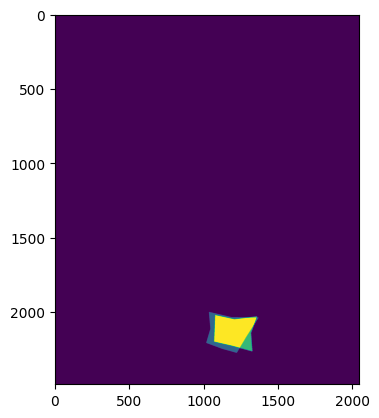

In [81]:
S1 = np.load(os.path.join(gt_path,'L02425_S1.npy'))
L5 = np.load(os.path.join(gt_path,'L02425_L5.npy'))
plt.imshow(S1+2*L5)
#plt.imshow(base_img)

In [82]:
print(labels['C04872_2'])

(283.0336820215024, 77.6589045057869)


In [6]:
np_input_points = np.array(input_points)
np_output_points = np.array(output_points)

os.makedirs(os.path.join(data_path,'..','point_predictor_data_v2'),exist_ok=True)

np.save(os.path.join(data_path,'..','point_predictor_data_v2',mode+'_input.npy'),np_input_points)
np.save(os.path.join(data_path,'..','point_predictor_data_v2',mode+'_output.npy'),np_output_points)

In [23]:
import pickle

os.makedirs(os.path.join(data_path,'points'),exist_ok=True)

pickle_dict = {}

for id,v_dict in centroid_dict.items():
    n=0
    for vid,centroid in v_dict.items():
        level = next(key for key, value in VERTEBRA_DICT.items() if value == vid)
        v_key = id+'_'+level
        pickle_dict[v_key] = (int(centroid[0]),int(centroid[1]))
        bg_key = id+'_BG'+str(n)
        n+=1
        pickle_dict[bg_key] = (0,0)

with open(os.path.join(data_path,'points',mode+'.pkl'),'wb') as f:
    pickle.dump(pickle_dict,f)

In [9]:
with open(os.path.join(data_path,'points',mode+'.pkl'),'rb') as f:
    loaded = pickle.load(f)

print(loaded)

{'C00166_C2': (773, 1035), 'C00166_BG0': (0, 0), 'C00166_C3': (673, 1147), 'C00166_BG1': (0, 0), 'C00166_C4': (600, 1202), 'C00166_BG2': (0, 0), 'C00166_C5': (515, 1249), 'C00166_BG3': (0, 0), 'C00166_C6': (448, 1311), 'C00166_BG4': (0, 0), 'C00166_C7': (368, 1376), 'C00166_BG5': (0, 0), 'C00174_C2': (1197, 529), 'C00174_BG0': (0, 0), 'C00174_C3': (1093, 636), 'C00174_BG1': (0, 0), 'C00174_C4': (1020, 719), 'C00174_BG2': (0, 0), 'C00174_C5': (948, 810), 'C00174_BG3': (0, 0), 'C00174_C6': (879, 888), 'C00174_BG4': (0, 0), 'C00179_C2': (1017, 918), 'C00179_BG0': (0, 0), 'C00179_C3': (912, 1021), 'C00179_BG1': (0, 0), 'C00179_C4': (833, 1089), 'C00179_BG2': (0, 0), 'C00179_C5': (743, 1142), 'C00179_BG3': (0, 0), 'C00179_C6': (668, 1197), 'C00179_BG4': (0, 0), 'C00197_C2': (996, 943), 'C00197_BG0': (0, 0), 'C00197_C3': (895, 1062), 'C00197_BG1': (0, 0), 'C00197_C4': (828, 1143), 'C00197_BG2': (0, 0), 'C00197_C5': (758, 1222), 'C00197_BG3': (0, 0), 'C00197_C6': (704, 1305), 'C00197_BG4': (0

In [10]:
print(os.getcwd())

/gpfs3/well/papiez/users/saa032/projects/Medical-SAM-Adapter
